# Compute MOC along the approximate OSNAP array from ECCO

Here we compute volumetric transport along the OSNAP lines in depth space, which can be compared to recent observations. 

Here we show:

* how to get masks denoting the great circle arc between two points in space

* how to compute the transport or streamfunction across this section

* a comparison to observations

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy as cart
import cartopy.crs as ccrs
notebook_path = os.getcwd()

In [3]:
## Import the ecco_v4_py library into Python
## =========================================

## -- If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  For example, if your ecco_v4_py
##    files are in /Users/ifenty/ECCOv4-py/ecco_v4_py, then use:

sys.path.append('/Users/ifenty/ECCOv4-py')
import ecco_v4_py as ecco

In [4]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================
# base_dir = '/home/username/'
base_dir = '/Users/ifenty/ECCOv4-release'

## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/Release3_alt'

In [5]:
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'

ecco_grid = ecco.load_ecco_grid_nc(grid_dir)

## Load one year of 2D daily data, SSH, SST, and SSS 
data_dir= ECCO_dir + '/nctiles_monthly'

ecco_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['ADVx_TH', 'ADVy_TH', \
                                                        'UVELMASS', 'VVELMASS'],\
                                           years_to_load = range(2008,2014))
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ds = xr.merge((ecco_grid , ecco_vars))

searching /Users/ifenty/ECCOv4-release/Release3_alt/nctiles_monthly for variables ... 
found  ['ADVr_SLT', 'ADVr_TH', 'ADVxHEFF', 'ADVxSNOW', 'ADVx_SLT', 'ADVx_TH', 'ADVyHEFF', 'ADVySNOW', 'ADVy_SLT', 'ADVy_TH', 'DFrE_SLT', 'DFrE_TH', 'DFrI_SLT', 'DFrI_TH', 'DFxEHEFF', 'DFxESNOW', 'DFxE_SLT', 'DFxE_TH', 'DFyEHEFF', 'DFyESNOW', 'DFyE_SLT', 'DFyE_TH', 'DRHODR', 'ETAN', 'EXFaqh', 'EXFatemp', 'EXFempmr', 'EXFevap', 'EXFhl', 'EXFhs', 'EXFlwdn', 'EXFlwnet', 'EXFpreci', 'EXFqnet', 'EXFroff', 'EXFswdn', 'EXFswnet', 'EXFtaux', 'EXFtauy', 'EXFuwind', 'EXFvwind', 'EXFwspee', 'GM_PsiX', 'GM_PsiY', 'MXLDEPTH', 'OBP', 'PHIBOT', 'PHIHYD', 'PHIHYDcR', 'RHOAnoma', 'SALT', 'SFLUX', 'SIarea', 'SIatmFW', 'SIatmQnt', 'SIheff', 'SIhsnow', 'SIsnPrcp', 'SIuice', 'SIvice', 'SSH', 'TFLUX', 'THETA', 'UVEL', 'UVELMASS', 'Um_dPHdx', 'VVEL', 'VVELMASS', 'Vm_dPHdy', 'WVELMASS', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSPDep', 'oceSPflx', 'oceSPtnd', 'oceTAUX', 'oceTAUY', 'sIceLoad'] 

finished searching for ADVx_TH ... 

## Define the OSNAP lines 

We define the OSNAP lines roughly by point pairs in `[longitude, latitude]` space. 
The lines are then computed via the function `ecco_v4_py.get_section_line_masks` as the great circle arc between these two points. 

See below for similar MATLAB functions

In [6]:
pt1_east = [-44, 60]
pt2_east = [-5, 56]

pt1_west = [-56, 51]
pt2_west = [-45, 60]

In [7]:
maskC_east, maskW_east, maskS_east = ecco.get_section_line_masks(pt1_east,pt2_east,ds)
maskC_west, maskW_west, maskS_west = ecco.get_section_line_masks(pt1_west,pt2_west,ds)
maskC_tot = (maskC_east+maskC_west).where(maskC_east+maskC_west==1,0)
maskW_tot = (maskW_east+maskW_west).where(np.abs(maskW_east)+np.abs(maskW_west)==1,0)
maskS_tot = (maskS_east+maskS_west).where(np.abs(maskS_east)+np.abs(maskS_west)==1,0)

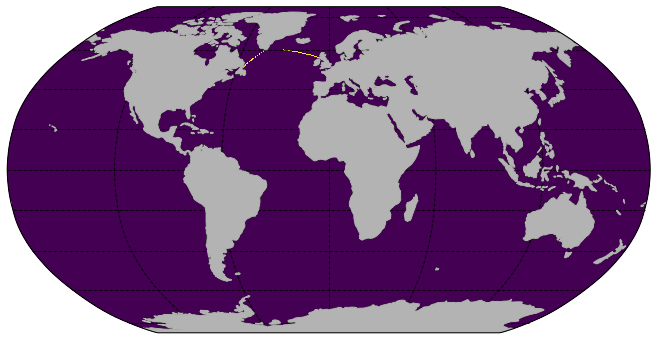

In [8]:
plt.figure(figsize=(12,6))
fig,ax,p,cb = ecco.plot_proj_to_latlon_grid(ds.XC,ds.YC,maskC_tot,cmap='viridis',projection_type='robin',user_lon_0=0)
ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
plt.show()

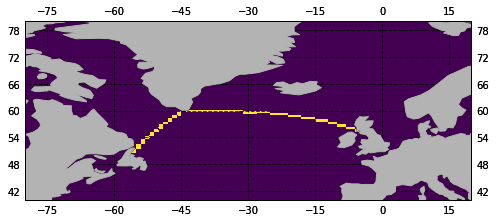

In [9]:
plt.figure(figsize=(8,8))
# use dx=.1, dy=.1 so that plot shows the osnap array as a thin 
# line.  remember, plot_proj_to_latlon_grid first interpolates
# the model grid to lat-lon with grid spacing as dx, dy
fig,ax,p,cb = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC, maskC_tot, \
                                            cmap='viridis',\
                                            projection_type='PlateCaree',\
                                            lat_lim=45,dx=.1,dy=.1)
ax.add_feature(cart.feature.LAND,facecolor='0.7',zorder=2)
ax.set_extent([-80, 20, 40, 80], crs=ccrs.PlateCarree())
plt.show()

We have defined many commonly used sections in oceanography so that users can access these easily. 
The available sections are shown below. 
This allows one to, e.g. compute volumetric transport across the Drake Passage as follows:

```
drake_vol = ecco_v4_py.calc_section_vol_trsp(ds,section_name='Drake Passage')
```

Similarly, we can do the same with `calc_section_heat_trsp` and `calc_section_salt_trsp`. 

One can also get these pre-defined section masks as follows:

```
pt1,pt2 = ecco_v4_py.get_section_endpoints('Drake Passage')
maskC, maskW, maskS = ecco_v4_py.get_section_line_masks(ds,pt1,pt2)
```

Finally, one can see similar functions in MATLAB:

* define general section masks: [gcmfaces_calc/gcmfaces_lines_transp.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/gcmfaces_lines_transp.m)

* see pre-defined section endpoints: [gcmfaces_calc/gcmfaces_lines_pairs.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/gcmfaces_lines_pairs.m)

In [10]:
ecco.get_available_sections()

['Bering Strait',
 'Gibraltar',
 'Florida Strait',
 'Florida Strait W1',
 'Florida Strait S1',
 'Florida Strait E1',
 'Florida Strait E2',
 'Florida Strait E3',
 'Florida Strait E4',
 'Davis Strait',
 'Denmark Strait',
 'Iceland Faroe',
 'Faroe Scotland',
 'Scotland Norway',
 'Drake Passage',
 'Indonesia W1',
 'Indonesia W2',
 'Indonesia W3',
 'Indonesia W4',
 'Australia Antarctica',
 'Madagascar Channel',
 'Madagascar Antarctica',
 'South Africa Antarctica']

## Compute the overturning streamfunction in depth space

The function `calc_section_stf` computes the overturning streamfunction across the plane normal to the section denoted by the west and south masks. 
It is also possible to compute the overturning streamfunction at a particular latitude band, as is done to compare to the RAPID array, for instance. 
Please see the function `calc_meridional_stf` to do this, which is also in 
[ecco_v4_py.calc_stf](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_stf.py).

Note that we can also compute the volumetric, heat, or salt transport across these sections using the first three functions defined in [ecco_v4_py.calc_section_trsp](https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/calc_section_trsp.py).

In MATLAB, we can compute meridional overturning streamfunctions with [gcmfaces_calc/calc_overturn.m](https://github.com/ECCO-GROUP/gcmfaces/blob/master/gcmfaces_calc/calc_overturn.m).
Section transports can be computed with [gcmfaces_calc/calc_transports.m](https://github.com/gaelforget/gcmfaces/blob/readthedocs/gcmfaces_calc/calc_transports.m) once the masks are defined.

In [11]:
%%time
osnap_z_stf_east = ecco.calc_section_stf(ds,\
                                         pt1=pt1_east, \
                                         pt2=pt2_east,\
                                         section_name='OSNAP East Overturning Streamfunction').compute()

osnap_z_stf_west = ecco.calc_section_stf(ds, \
                                         pt1=pt1_west, \
                                         pt2=pt2_west,\
                                         section_name='OSNAP West Overturning Streamfunction').compute()

osnap_z_stf_tot = ecco.calc_section_stf(ds,\
                                        maskW=maskW_tot, \
                                        maskS=maskS_tot,\
                                        section_name='OSNAP Total Overturning Streamfunction').compute()

CPU times: user 46.5 s, sys: 1min 53s, total: 2min 39s
Wall time: 49.6 s


In [12]:
def osnap_depth_stf_vs_time(stf_ds,label):
    fig = plt.figure(figsize=(18,6))
    
    # Time evolving
    plt.subplot(1,4,(1,3))
    plt.pcolormesh(stf_ds['time'],stf_ds['Z'],stf_ds['psi_moc'].T)
    plt.title('ECCOv4r3\nOverturning streamfunction across OSNAP %s [Sv]' % label)
    plt.ylabel('Depth [m]')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    cb = plt.colorbar()
    cb.set_label('[Sv]')
    
    plt.subplot(1,4,4)
    plt.plot(stf_ds['psi_moc'].mean('time'),stf_ds['Z'])
    plt.title('ECCOv4r3\nTime mean streamfunction, OSNAP %s' % label)
    plt.ylabel('Depth [m]')
    plt.xlabel('[Sv]')
    plt.grid()
    plt.show()

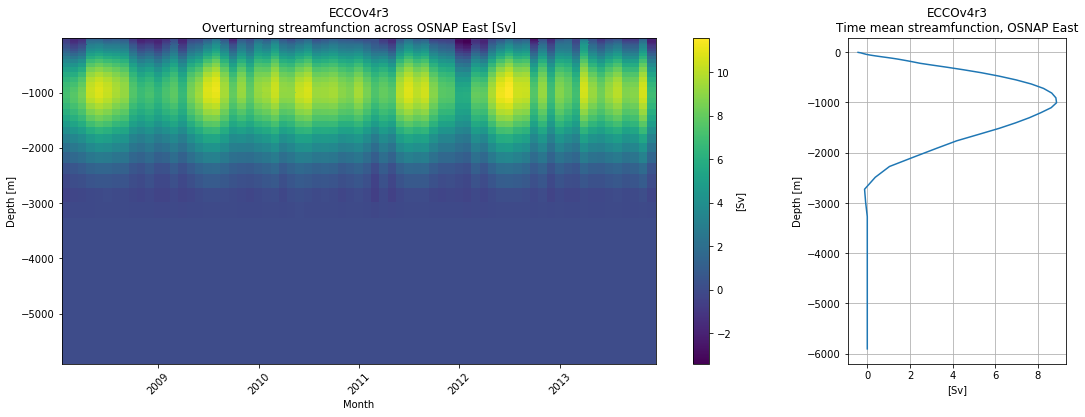

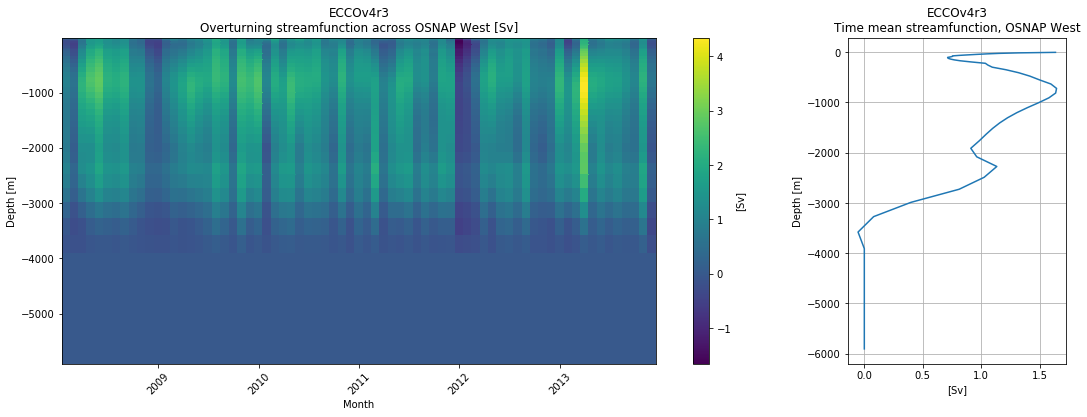

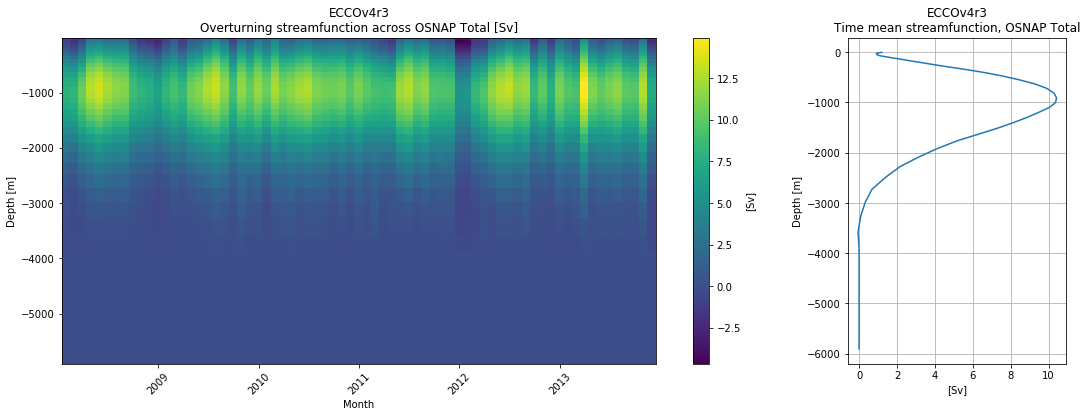

In [13]:
osnap_depth_stf_vs_time(osnap_z_stf_east,'East')
osnap_depth_stf_vs_time(osnap_z_stf_west,'West')
osnap_depth_stf_vs_time(osnap_z_stf_tot,'Total')

In [14]:
osnap_z_ov_east = osnap_z_stf_east['psi_moc'].max(dim='k')
osnap_z_ov_west = osnap_z_stf_west['psi_moc'].max(dim='k')
osnap_z_ov_tot = osnap_z_stf_tot['psi_moc'].max(dim='k')

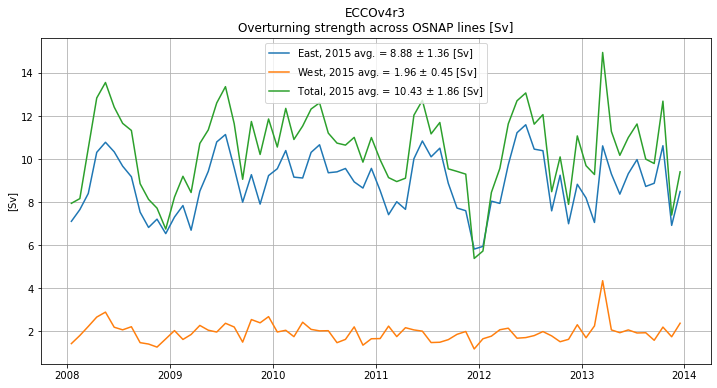

In [15]:
fig = plt.figure(figsize=(12,6))
plt.plot(osnap_z_ov_east['time'],osnap_z_ov_east)
plt.plot(osnap_z_ov_west['time'],osnap_z_ov_west)
plt.plot(osnap_z_ov_tot['time'],osnap_z_ov_tot)
plt.title('ECCOv4r3\nOverturning strength across OSNAP lines [Sv]')
plt.ylabel('[Sv]')
plt.legend((('East, 2015 avg. = %.2f $\pm$ %.2f [Sv]' % 
             (osnap_z_ov_east.mean('time').values,osnap_z_ov_east.std('time').values)),
            ('West, 2015 avg. = %.2f $\pm$ %.2f [Sv]' % 
             (osnap_z_ov_west.mean('time').values,osnap_z_ov_west.std('time').values)),
            ('Total, 2015 avg. = %.2f $\pm$ %.2f [Sv]' % 
             (osnap_z_ov_tot.mean('time').values,osnap_z_ov_tot.std('time').values))))
plt.grid()
plt.show()

## Compare to Observations

These data are available at https://www.o-snap.org/observations/data/ and are published in

Lozier, M. S., Li, F., Bacon, S., Bahr, F., Bower, A. S., Cunningham, S. A., … Zhao, J. (2019). A sea change in our view of overturning in the subpolar North Atlantic. Science, 363(6426), 516–521. https://doi.org/10.1126/science.aau6592

In [18]:
obs1 = xr.open_dataset(ecco_path + '/../bin/OSNAP_West_East_Transports_201408_201604_2018.nc')
obs2 = xr.open_dataset(ecco_path + '/../bin/OSNAP_Transports_201408_201604_2018.nc')
obs = xr.merge((obs1,obs2))
print(obs)

<xarray.Dataset>
Dimensions:             (TIME: 21)
Coordinates:
  * TIME                (TIME) datetime64[ns] 2014-07-31 ... 2016-03-22
Data variables:
    MOC_WEST_SIGMA      (TIME) float64 ...
    MOC_WEST_SIGMA_ERR  (TIME) float64 ...
    MOC_WEST_Z          (TIME) float64 ...
    MOC_WEST_Z_ERR      (TIME) float64 ...
    MHT_WEST            (TIME) float64 ...
    MHT_WEST_ERR        (TIME) float64 ...
    MFT_WEST            (TIME) float64 ...
    MFT_WEST_ERR        (TIME) float64 ...
    MOC_EAST_SIGMA      (TIME) float64 ...
    MOC_EAST_SIGMA_ERR  (TIME) float64 ...
    MOC_EAST_Z          (TIME) float64 ...
    MOC_EAST_Z_ERR      (TIME) float64 ...
    MHT_EAST            (TIME) float64 ...
    MHT_EAST_ERR        (TIME) float64 ...
    MFT_EAST            (TIME) float64 ...
    MFT_EAST_ERR        (TIME) float64 ...
    MOC_SIGMA           (TIME) float64 ...
    MOC_SIGMA_ERR       (TIME) float64 ...
    MOC_Z               (TIME) float64 ...
    MOC_Z_ERR           (TIME)

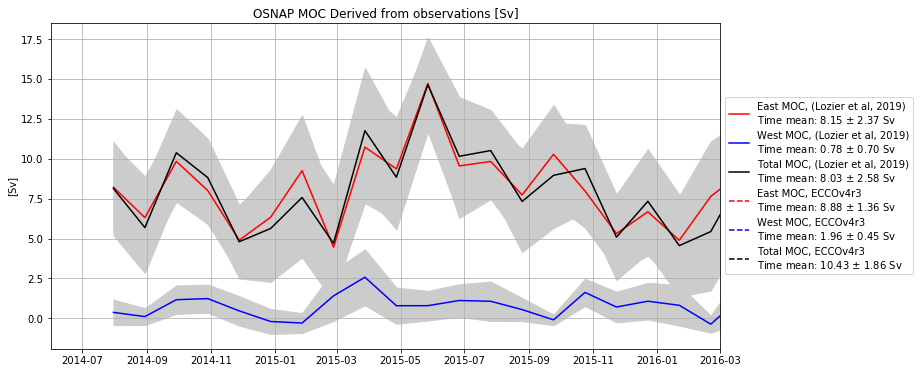

In [19]:
plt.figure(figsize=(12,6))

var_list = ['MOC_EAST_Z','MOC_WEST_Z','MOC_Z']
err_list = ['MOC_EAST_Z_ERR','MOC_WEST_Z_ERR','MOC_Z_ERR']
for var, err in zip(var_list,err_list):
    if 'MOC_Z' in var:
        clr = 'k'
    elif 'MOC_EAST_Z' in var:
        clr = 'r'
    elif 'MOC_WEST_Z' in var:
        clr = 'b'
    
        
    plt.plot(obs['TIME'],obs[var], color=clr)
    
    plt.fill_between(obs['TIME'].values,
                 obs[var]-obs[err],
                 obs[var]+obs[err],
                 color=[0.8,0.8,0.8])

# plot ECCO v4r3 equivalent
plt.plot(osnap_z_ov_east['time'],osnap_z_ov_east, 'r--')
plt.plot(osnap_z_ov_west['time'],osnap_z_ov_west, 'b--',)
plt.plot(osnap_z_ov_tot['time'],osnap_z_ov_tot, 'k--')
plt.xlim(('2014-06','2016-03'))

plt.ylabel('[%s]' % obs['MOC_Z'].units)
plt.grid()
plt.title('OSNAP MOC Derived from observations [%s]' % obs['MOC_Z'].units)
plt.legend((
    ('East MOC, (Lozier et al, 2019)\nTime mean: %.2f $\pm$ %.2f %s' % 
            (obs['MOC_EAST_Z'].mean('TIME'),obs['MOC_EAST_Z'].std('TIME'),obs['MOC_EAST_Z'].units)),
    ('West MOC, (Lozier et al, 2019)\nTime mean: %.2f $\pm$ %.2f %s' % 
            (obs['MOC_WEST_Z'].mean('TIME'),obs['MOC_WEST_Z'].std('TIME'),obs['MOC_WEST_Z'].units)),
    ('Total MOC, (Lozier et al, 2019)\nTime mean: %.2f $\pm$ %.2f %s' % 
            (obs['MOC_Z'].mean('TIME'),obs['MOC_Z'].std('TIME'),obs['MOC_Z'].units)),
    ('East MOC, ECCOv4r3\nTime mean: %.2f $\pm$ %.2f %s' % 
            (osnap_z_ov_east.mean('time'),osnap_z_ov_east.std('time'), \
             osnap_z_stf_east['psi_moc'].attrs['units'])),
    ('West MOC, ECCOv4r3\nTime mean: %.2f $\pm$ %.2f %s' % 
            (osnap_z_ov_west.mean('time'),osnap_z_ov_west.std('time'), \
             osnap_z_stf_west['psi_moc'].attrs['units'])),
    ('Total MOC, ECCOv4r3\nTime mean: %.2f $\pm$ %.2f %s' % 
            (osnap_z_ov_tot.mean('time'),osnap_z_ov_tot.std('time'), \
             osnap_z_stf_tot['psi_moc'].attrs['units']))),
    loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()